In [1]:
import os
import sys

import nltk

# NER
from nltk.tag.stanford import StanfordNERTagger
jar = './stanford-ner.jar'
model = './ner-model-indonesia.ser.gz'

# Prepare NER tagger with english model
ner_tagger = StanfordNERTagger(model, jar, encoding='utf8')

# import StemmerFactory class
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [2]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K

K.set_session(sess)
K.set_learning_phase(0)

import numpy as np
import random

from keras.applications import VGG19
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import utils
from keras import layers
from keras.optimizers import adam

import matplotlib.pyplot as plt

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import utils
from tensorflow.python.saved_model import tag_constants, signature_constants
from tensorflow.python.saved_model.signature_def_utils_impl import build_signature_def, predict_signature_def
from tensorflow.contrib.session_bundle import exporter

In [4]:
model_version = "2"

In [5]:
# import our chat-bot intents file
import json
with open('intents.json') as json_data:
    intents = json.load(json_data)

In [6]:
words = []
classes = []
documents = []
ignore_words = ['?']
# loop through each sentence in our intents patterns
for intent in intents['intents']:
    for pattern in intent['utterances']:
        # tokenize each word in the sentence
        w = nltk.word_tokenize(pattern)
        # add to our words list
        words.extend(w)
        # add to documents in our corpus
        documents.append((w, intent['intent']))
        # add to our classes list
        if intent['intent'] not in classes:
            classes.append(intent['intent'])

# stem and lower each word and remove duplicates
words = [stemmer.stem(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

# remove duplicates
classes = sorted(list(set(classes)))

print (len(documents), "documents")
print (len(classes), "classes", classes)
print (len(words), "unique stemmed words", words)

55 documents
16 classes ['appointment', 'appointmentForSomeone', 'appointmentWithDate', 'appointmentWithDoctor', 'cancelAppointment', 'concern', 'doctor', 'goodbye', 'greeting', 'insurance', 'medsTaken', 'noMedsTaken', 'numbOfDays', 'openingHours', 'pain', 'paymentMethod']
78 unique stemmed words ['', 'allianz', 'anak', 'apa', 'apakah', 'asuransi', 'axa', 'bambang', 'bapak', 'batal', 'bayar', 'belum', 'berapa', 'besok', 'bisa', 'bpjs', 'buat', 'buka', 'bye', 'dan', 'debit', 'dengan', 'di', 'dokter', 'dr', 'goodbye', 'halo', 'hari', 'hello', 'hi', 'ibu', 'ingin', 'ini', 'insurance', 'istri', 'jam', 'janji', 'kabar', 'kartu', 'keluh', 'kemarin', 'kepala', 'kredit', 'layan', 'lemas', 'lippo', 'malam', 'mastercard', 'meriang', 'minum', 'nanti', 'obat', 'pagi', 'pakai', 'payment', 'periksa', 'perut', 'pinggang', 'pusing', 'rasa', 'sakit', 'saya', 'sejak', 'selamat', 'siang', 'siapa', 'simasnet', 'smarthealth', 'sore', 'suami', 'sudah', 'tadi', 'terima', 'tinggal', 'tugas', 'untuk', 'visa', 

In [7]:
# create our training data
training = []
output = []
# create an empty array for our output
output_empty = [0] * len(classes)

# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # stem each word
    pattern_words = [stemmer.stem(word.lower()) for word in pattern_words]
    # create our bag of words array
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output is a '0' for each tag and '1' for current tag
    output_row = list(output_empty)
    #print(classes.index(doc[1]))
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])
    
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)

# create train and test lists
train_x = list(training[:,0])
train_y = list(training[:,1])

In [8]:
model = Sequential()
model.add(Dense(8, input_shape=[len(train_x[0],)]))
model.add(Dense(8))
model.add(Dense(8))
model.add(Dense(len(train_y[0]), activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer=tf.train.AdamOptimizer(), metrics=['acc'])
history = model.fit(np.array(train_x), np.array(train_y), epochs=1000, batch_size=8)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 632       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 16)                144       
Total params: 920
Trainable params: 920
Non-trainable params: 0
_________________________________________________________________



Epoch 1/1000
55/55 [==============================] - 0s 3ms/step - loss: 2.8445 - acc: 0.0727
Epoch 2/1000
55/55 [==============================] - 0s 313us/step - loss: 2.8094 - acc: 0.1091
Epoch 3/1000
55/55 [==============================] - 0s 33

55/55 [==============================] - 0s 269us/step - loss: 0.6195 - acc: 0.7636
Epoch 70/1000
55/55 [==============================] - 0s 359us/step - loss: 0.6066 - acc: 0.7636
Epoch 71/1000
55/55 [==============================] - 0s 288us/step - loss: 0.5931 - acc: 0.7636
Epoch 72/1000
55/55 [==============================] - 0s 368us/step - loss: 0.5808 - acc: 0.7636
Epoch 73/1000
55/55 [==============================] - 0s 362us/step - loss: 0.5683 - acc: 0.7636
Epoch 74/1000
55/55 [==============================] - 0s 246us/step - loss: 0.5567 - acc: 0.7636
Epoch 75/1000
55/55 [==============================] - 0s 353us/step - loss: 0.5456 - acc: 0.7636
Epoch 76/1000
55/55 [==============================] - 0s 328us/step - loss: 0.5336 - acc: 0.7636
Epoch 77/1000
55/55 [==============================] - 0s 395us/step - loss: 0.5237 - acc: 0.7636
Epoch 78/1000
55/55 [==============================] - 0s 315us/step - loss: 0.5124 - acc: 0.7818
Epoch 79/1000
55/55 [=============

55/55 [==============================] - 0s 230us/step - loss: 0.0532 - acc: 1.0000
Epoch 153/1000
55/55 [==============================] - 0s 346us/step - loss: 0.0517 - acc: 1.0000
Epoch 154/1000
55/55 [==============================] - 0s 321us/step - loss: 0.0501 - acc: 1.0000
Epoch 155/1000
55/55 [==============================] - 0s 265us/step - loss: 0.0487 - acc: 1.0000
Epoch 156/1000
55/55 [==============================] - 0s 271us/step - loss: 0.0473 - acc: 1.0000
Epoch 157/1000
55/55 [==============================] - 0s 328us/step - loss: 0.0462 - acc: 1.0000
Epoch 158/1000
55/55 [==============================] - 0s 335us/step - loss: 0.0447 - acc: 1.0000
Epoch 159/1000
55/55 [==============================] - 0s 329us/step - loss: 0.0435 - acc: 1.0000
Epoch 160/1000
55/55 [==============================] - 0s 294us/step - loss: 0.0423 - acc: 1.0000
Epoch 161/1000
55/55 [==============================] - 0s 276us/step - loss: 0.0411 - acc: 1.0000
Epoch 162/1000
55/55 [===

55/55 [==============================] - 0s 321us/step - loss: 0.0095 - acc: 1.0000
Epoch 235/1000
55/55 [==============================] - 0s 351us/step - loss: 0.0094 - acc: 1.0000
Epoch 236/1000
55/55 [==============================] - 0s 307us/step - loss: 0.0092 - acc: 1.0000
Epoch 237/1000
55/55 [==============================] - 0s 317us/step - loss: 0.0091 - acc: 1.0000
Epoch 238/1000
55/55 [==============================] - 0s 298us/step - loss: 0.0090 - acc: 1.0000
Epoch 239/1000
55/55 [==============================] - 0s 329us/step - loss: 0.0088 - acc: 1.0000
Epoch 240/1000
55/55 [==============================] - 0s 363us/step - loss: 0.0087 - acc: 1.0000
Epoch 241/1000
55/55 [==============================] - 0s 342us/step - loss: 0.0086 - acc: 1.0000
Epoch 242/1000
55/55 [==============================] - 0s 285us/step - loss: 0.0085 - acc: 1.0000
Epoch 243/1000
55/55 [==============================] - 0s 285us/step - loss: 0.0083 - acc: 1.0000
Epoch 244/1000
55/55 [===

55/55 [==============================] - 0s 647us/step - loss: 0.0035 - acc: 1.0000
Epoch 317/1000
55/55 [==============================] - 0s 780us/step - loss: 0.0035 - acc: 1.0000
Epoch 318/1000
55/55 [==============================] - 0s 289us/step - loss: 0.0035 - acc: 1.0000
Epoch 319/1000
55/55 [==============================] - 0s 268us/step - loss: 0.0034 - acc: 1.0000
Epoch 320/1000
55/55 [==============================] - 0s 272us/step - loss: 0.0034 - acc: 1.0000
Epoch 321/1000
55/55 [==============================] - 0s 314us/step - loss: 0.0034 - acc: 1.0000
Epoch 322/1000
55/55 [==============================] - 0s 435us/step - loss: 0.0033 - acc: 1.0000
Epoch 323/1000
55/55 [==============================] - 0s 425us/step - loss: 0.0033 - acc: 1.0000
Epoch 324/1000
55/55 [==============================] - 0s 390us/step - loss: 0.0033 - acc: 1.0000
Epoch 325/1000
55/55 [==============================] - 0s 301us/step - loss: 0.0032 - acc: 1.0000
Epoch 326/1000
55/55 [===

55/55 [==============================] - 0s 332us/step - loss: 0.0017 - acc: 1.0000
Epoch 399/1000
55/55 [==============================] - 0s 374us/step - loss: 0.0017 - acc: 1.0000
Epoch 400/1000
55/55 [==============================] - 0s 341us/step - loss: 0.0017 - acc: 1.0000
Epoch 401/1000
55/55 [==============================] - 0s 386us/step - loss: 0.0017 - acc: 1.0000
Epoch 402/1000
55/55 [==============================] - 0s 270us/step - loss: 0.0017 - acc: 1.0000
Epoch 403/1000
55/55 [==============================] - 0s 247us/step - loss: 0.0016 - acc: 1.0000
Epoch 404/1000
55/55 [==============================] - 0s 282us/step - loss: 0.0016 - acc: 1.0000
Epoch 405/1000
55/55 [==============================] - 0s 254us/step - loss: 0.0016 - acc: 1.0000
Epoch 406/1000
55/55 [==============================] - 0s 290us/step - loss: 0.0016 - acc: 1.0000
Epoch 407/1000
55/55 [==============================] - 0s 302us/step - loss: 0.0016 - acc: 1.0000
Epoch 408/1000
55/55 [===

55/55 [==============================] - 0s 297us/step - loss: 9.4832e-04 - acc: 1.0000
Epoch 481/1000
55/55 [==============================] - 0s 263us/step - loss: 9.4229e-04 - acc: 1.0000
Epoch 482/1000
55/55 [==============================] - 0s 289us/step - loss: 9.3632e-04 - acc: 1.0000
Epoch 483/1000
55/55 [==============================] - 0s 318us/step - loss: 9.3031e-04 - acc: 1.0000
Epoch 484/1000
55/55 [==============================] - 0s 309us/step - loss: 9.2392e-04 - acc: 1.0000
Epoch 485/1000
55/55 [==============================] - 0s 286us/step - loss: 9.1777e-04 - acc: 1.0000
Epoch 486/1000
55/55 [==============================] - 0s 324us/step - loss: 9.1219e-04 - acc: 1.0000
Epoch 487/1000
55/55 [==============================] - 0s 299us/step - loss: 9.0589e-04 - acc: 1.0000
Epoch 488/1000
55/55 [==============================] - 0s 307us/step - loss: 8.9966e-04 - acc: 1.0000
Epoch 489/1000
55/55 [==============================] - 0s 240us/step - loss: 8.9387e-04

55/55 [==============================] - 0s 289us/step - loss: 5.7918e-04 - acc: 1.0000
Epoch 560/1000
55/55 [==============================] - 0s 298us/step - loss: 5.7559e-04 - acc: 1.0000
Epoch 561/1000
55/55 [==============================] - 0s 310us/step - loss: 5.7261e-04 - acc: 1.0000
Epoch 562/1000
55/55 [==============================] - 0s 325us/step - loss: 5.6901e-04 - acc: 1.0000
Epoch 563/1000
55/55 [==============================] - 0s 265us/step - loss: 5.6579e-04 - acc: 1.0000
Epoch 564/1000
55/55 [==============================] - 0s 297us/step - loss: 5.6241e-04 - acc: 1.0000
Epoch 565/1000
55/55 [==============================] - 0s 311us/step - loss: 5.5906e-04 - acc: 1.0000
Epoch 566/1000
55/55 [==============================] - 0s 296us/step - loss: 5.5582e-04 - acc: 1.0000
Epoch 567/1000
55/55 [==============================] - 0s 269us/step - loss: 5.5272e-04 - acc: 1.0000
Epoch 568/1000
55/55 [==============================] - 0s 245us/step - loss: 5.4933e-04

55/55 [==============================] - 0s 229us/step - loss: 3.7099e-04 - acc: 1.0000
Epoch 639/1000
55/55 [==============================] - 0s 258us/step - loss: 3.6881e-04 - acc: 1.0000
Epoch 640/1000
55/55 [==============================] - 0s 359us/step - loss: 3.6669e-04 - acc: 1.0000
Epoch 641/1000
55/55 [==============================] - 0s 300us/step - loss: 3.6504e-04 - acc: 1.0000
Epoch 642/1000
55/55 [==============================] - 0s 260us/step - loss: 3.6282e-04 - acc: 1.0000
Epoch 643/1000
55/55 [==============================] - 0s 313us/step - loss: 3.6091e-04 - acc: 1.0000
Epoch 644/1000
55/55 [==============================] - 0s 402us/step - loss: 3.5886e-04 - acc: 1.0000
Epoch 645/1000
55/55 [==============================] - 0s 337us/step - loss: 3.5709e-04 - acc: 1.0000
Epoch 646/1000
55/55 [==============================] - 0s 490us/step - loss: 3.5508e-04 - acc: 1.0000
Epoch 647/1000
55/55 [==============================] - 0s 317us/step - loss: 3.5313e-04

55/55 [==============================] - 0s 289us/step - loss: 2.4511e-04 - acc: 1.0000
Epoch 718/1000
55/55 [==============================] - 0s 449us/step - loss: 2.4375e-04 - acc: 1.0000
Epoch 719/1000
55/55 [==============================] - 0s 342us/step - loss: 2.4251e-04 - acc: 1.0000
Epoch 720/1000
55/55 [==============================] - 0s 380us/step - loss: 2.4135e-04 - acc: 1.0000
Epoch 721/1000
55/55 [==============================] - 0s 317us/step - loss: 2.4027e-04 - acc: 1.0000
Epoch 722/1000
55/55 [==============================] - 0s 318us/step - loss: 2.3889e-04 - acc: 1.0000
Epoch 723/1000
55/55 [==============================] - 0s 329us/step - loss: 2.3757e-04 - acc: 1.0000
Epoch 724/1000
55/55 [==============================] - 0s 328us/step - loss: 2.3659e-04 - acc: 1.0000
Epoch 725/1000
55/55 [==============================] - 0s 284us/step - loss: 2.3544e-04 - acc: 1.0000
Epoch 726/1000
55/55 [==============================] - 0s 309us/step - loss: 2.3422e-04

55/55 [==============================] - 0s 350us/step - loss: 1.6573e-04 - acc: 1.0000
Epoch 797/1000
55/55 [==============================] - 0s 280us/step - loss: 1.6494e-04 - acc: 1.0000
Epoch 798/1000
55/55 [==============================] - 0s 310us/step - loss: 1.6429e-04 - acc: 1.0000
Epoch 799/1000
55/55 [==============================] - 0s 345us/step - loss: 1.6341e-04 - acc: 1.0000
Epoch 800/1000
55/55 [==============================] - 0s 304us/step - loss: 1.6260e-04 - acc: 1.0000
Epoch 801/1000
55/55 [==============================] - 0s 318us/step - loss: 1.6181e-04 - acc: 1.0000
Epoch 802/1000
55/55 [==============================] - 0s 310us/step - loss: 1.6100e-04 - acc: 1.0000
Epoch 803/1000
55/55 [==============================] - 0s 356us/step - loss: 1.6025e-04 - acc: 1.0000
Epoch 804/1000
55/55 [==============================] - 0s 409us/step - loss: 1.5952e-04 - acc: 1.0000
Epoch 805/1000
55/55 [==============================] - 0s 444us/step - loss: 1.5876e-04

55/55 [==============================] - 0s 318us/step - loss: 1.1400e-04 - acc: 1.0000
Epoch 876/1000
55/55 [==============================] - 0s 305us/step - loss: 1.1349e-04 - acc: 1.0000
Epoch 877/1000
55/55 [==============================] - 0s 266us/step - loss: 1.1296e-04 - acc: 1.0000
Epoch 878/1000
55/55 [==============================] - 0s 320us/step - loss: 1.1244e-04 - acc: 1.0000
Epoch 879/1000
55/55 [==============================] - 0s 295us/step - loss: 1.1188e-04 - acc: 1.0000
Epoch 880/1000
55/55 [==============================] - ETA: 0s - loss: 9.2140e-05 - acc: 1.000 - 0s 443us/step - loss: 1.1136e-04 - acc: 1.0000
Epoch 881/1000
55/55 [==============================] - 0s 310us/step - loss: 1.1086e-04 - acc: 1.0000
Epoch 882/1000
55/55 [==============================] - 0s 290us/step - loss: 1.1034e-04 - acc: 1.0000
Epoch 883/1000
55/55 [==============================] - 0s 310us/step - loss: 1.0988e-04 - acc: 1.0000
Epoch 884/1000
55/55 [========================

55/55 [==============================] - 0s 307us/step - loss: 7.9391e-05 - acc: 1.0000
Epoch 955/1000
55/55 [==============================] - 0s 313us/step - loss: 7.9079e-05 - acc: 1.0000
Epoch 956/1000
55/55 [==============================] - 0s 229us/step - loss: 7.8665e-05 - acc: 1.0000
Epoch 957/1000
55/55 [==============================] - 0s 297us/step - loss: 7.8333e-05 - acc: 1.0000
Epoch 958/1000
55/55 [==============================] - 0s 362us/step - loss: 7.8010e-05 - acc: 1.0000
Epoch 959/1000
55/55 [==============================] - 0s 415us/step - loss: 7.7616e-05 - acc: 1.0000
Epoch 960/1000
55/55 [==============================] - 0s 439us/step - loss: 7.7269e-05 - acc: 1.0000
Epoch 961/1000
55/55 [==============================] - 0s 551us/step - loss: 7.6942e-05 - acc: 1.0000
Epoch 962/1000
55/55 [==============================] - 0s 472us/step - loss: 7.6626e-05 - acc: 1.0000
Epoch 963/1000
55/55 [==============================] - 0s 349us/step - loss: 7.6231e-05

In [11]:
export_path = 'folder_to_export/2'
builder = saved_model_builder.SavedModelBuilder(export_path)

signature = predict_signature_def(inputs={'images': model.input},
                                  outputs={'scores': model.output})

builder.add_meta_graph_and_variables(sess=sess,
                                        tags=[tag_constants.SERVING],
                                         signature_def_map={'predict': signature})
builder.save()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: folder_to_export/2/saved_model.pb


b'folder_to_export/2/saved_model.pb'

/usr/local/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


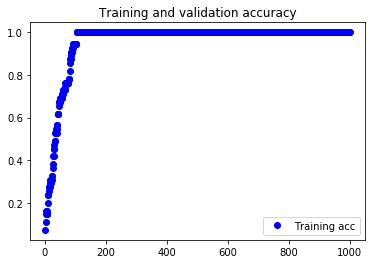

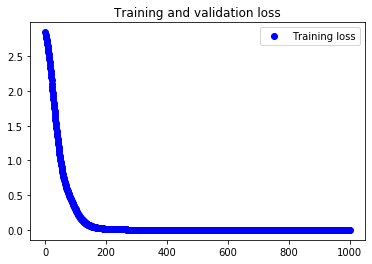

In [12]:
model.save('model_ChatBot.h5')
history_dict = history.history
history_dict.keys()
acc = history.history['acc']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [13]:
def clean_up_sentence(sentence):
    # tokenize the pattern
    sentence_words = nltk.word_tokenize(sentence)
    # stem each word
    sentence_words = [stemmer.stem(word.lower()) for word in sentence_words]
    return sentence_words

# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence
def bow(sentence, words, show_details=False):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    # bag of words
    bag = [0]*len(words)  
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s: 
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)

    return(np.array(bag))

In [29]:
# create a data structure to hold user context
context = {}

ERROR_THRESHOLD = 0.65
def classify(sentence):
    # generate probabilities from the model
    p = bow(sentence, words)
    
    d = len(p)
    f = len(documents)-2
    a = np.zeros([f, d])
    tot = np.vstack((p,a))
    
    results = model.predict(tot)[0]
    
    # filter out predictions below a threshold
    results = [[i,r] for i,r in enumerate(results) if r>ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append((classes[r[0]], r[1]))
    # return tuple of intent and probability
    return return_list

def response(sentence, userID, show_details=False):
    results = classify(sentence)
    
    entities = nltk.word_tokenize(sentence)
    tags = ner_tagger.tag(entities)
    print(tags)
    for t in tags:
        if t[1] is not 'O':
            print(t)
    
    print('Result:',results)
    print('Sentence:', sentence)
    # if we have a classification then find the matching intent tag
    if results:
        # loop as long as there are matches to process
        while results:
            for i in intents['intents']:
                # find a tag matching the first result
                if i['intent'] == results[0][0]:
                    # set context for this intent if necessary
                    if 'context_set' in i:
                        if show_details: print ('context:', i['context_set'])
                        context[userID] = i['context_set']

                    # check if this intent is contextual and applies to this user's conversation
                    if not 'context_filter' in i or \
                        (userID in context and 'context_filter' in i and i['context_filter'] == context[userID]):
                        if show_details: print ('intent:', i['intent'])
                        # a random response from the intent
                        return (random.choice(i['responses']))
            results.pop(0)
    else:
        print('No result')

In [31]:
response("Saya sakit sejak tadi pagi", '123', show_details=True)

[('Saya', 'O'), ('sakit', 'O'), ('sejak', 'O'), ('tadi', 'O'), ('pagi', 'TIME')]
('pagi', 'TIME')
Result: [('numbOfDays', 0.9999027)]
Sentence: Saya sakit sejak tadi pagi
intent: numbOfDays


'Apakah anda sudah meminum obat sebelum nya?'

In [32]:
context

{}